In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install tensorflow scikit-learn numpy pandas matplotlib keras opencv-python


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import cv2
from glob import glob
import random


In [ ]:

DATASET_PATH = "./drive/MyDrive/Thesis Files/Snake_Species_Dataset/"
# Path to the dataset
dataset_dir = DATASET_PATH
img_size = 128
num_classes = 11

def load_images(dataset_dir, img_size):
    images = []
    labels = []

    species_folders = os.listdir(dataset_dir)
    for label, species in enumerate(species_folders):
        species_path = os.path.join(dataset_dir, species)
        image_files = glob(species_path + '/*.jpg')

        for img_file in image_files:
            img = cv2.imread(img_file)
            img = cv2.resize(img, (img_size, img_size))
            images.append(img)
            labels.append(label)

    images = np.array(images)
    labels = np.array(labels)

    return images, labels

# Load labeled data
images, labels = load_images(dataset_dir, img_size)
labels = to_categorical(labels, num_classes)

# Split data into training and test sets
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Normalize pixel values
x_train = x_train / 255.0
x_test = x_test / 255.0


In [ ]:
def create_cnn_model(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))

    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))

    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

    return model

input_shape = (img_size, img_size, 3)
model = create_cnn_model(input_shape, num_classes)

# Train the model using supervised learning
history = model.fit(x_train, y_train, epochs=15, validation_data=(x_test, y_test), batch_size=32)


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - accuracy: 0.1763 - loss: 2.3018 - val_accuracy: 0.2506 - val_loss: 2.0496
Epoch 2/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - accuracy: 0.2588 - loss: 2.0225 - val_accuracy: 0.3463 - val_loss: 1.7951
Epoch 3/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - accuracy: 0.3274 - loss: 1.8403 - val_accuracy: 0.4388 - val_loss: 1.5782
Epoch 4/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.4012 - loss: 1.6526 - val_accuracy: 0.4755 - val_loss: 1.4583
Epoch 5/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.4611 - loss: 1.4776 - val_accuracy: 0.4610 - val_loss: 1.4347
Epoch 6/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.4958 - loss: 1.3840 - val_accuracy: 0.5323 - val_loss: 1.2942
Epoch 7/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.5333 - loss: 1.2548 - val_accuracy: 0.5479 - val_loss: 1.2162
Epoch 8/15
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.5615 - loss: 1.1498 - val_acc

In [ ]:
# Load unlabeled images for semi-supervised learning
unlabeled_dir = DATASET_PATH
unlabeled_images = load_images(unlabeled_dir, img_size)[0]
unlabeled_images = unlabeled_images / 255.0

# Predict pseudo-labels for the unlabeled images
pseudo_labels = model.predict(unlabeled_images)
pseudo_labels = np.argmax(pseudo_labels, axis=1)

# Filter pseudo-labeled images with high confidence
confidence_threshold = 0.95
high_confidence_images = []
high_confidence_labels = []

for i in range(len(unlabeled_images)):
    confidence = np.max(model.predict(np.expand_dims(unlabeled_images[i], axis=0)))
    if confidence > confidence_threshold:
        high_confidence_images.append(unlabeled_images[i])
        high_confidence_labels.append(pseudo_labels[i])

# Convert to arrays and one-hot encode labels
high_confidence_images = np.array(high_confidence_images)
high_confidence_labels = to_categorical(high_confidence_labels, num_classes)

# Merge pseudo-labeled data with labeled training data
x_train_semi = np.concatenate([x_train, high_confidence_images], axis=0)
y_train_semi = np.concatenate([y_train, high_confidence_labels], axis=0)

# Train the model again with combined labeled and pseudo-labeled data
history_semi = model.fit(x_train_semi, y_train_semi, epochs=10, validation_data=(x_test, y_test), batch_size=32)


141/141 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━

In [ ]:
# Evaluate the model performance
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc * 100:.2f}%")

# Classification report
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)
print(classification_report(y_true_classes, y_pred_classes))


29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6375 - loss: 1.8639
Test accuracy: 62.14%
29/29 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
              precision    recall  f1-score   support

           0       0.78      0.87      0.82        54
           1       0.55      0.67      0.61       137
           2       0.69      0.87      0.77       150
           3       0.50      0.43      0.46        28
           4       0.53      0.69      0.60        65
           5       0.41      0.19      0.26        57
           6       0.44      0.19      0.27        21
           7       0.57      0.48      0.52       105
           8       0.51      0.35      0.42        57
           9       0.79      0.74      0.76       170
          10       0.42      0.41      0.41        54

    accuracy                           0.62       898
   macro avg       0.56      0.53      0.54       898
weighted avg       0.61      0.62      0.61       898



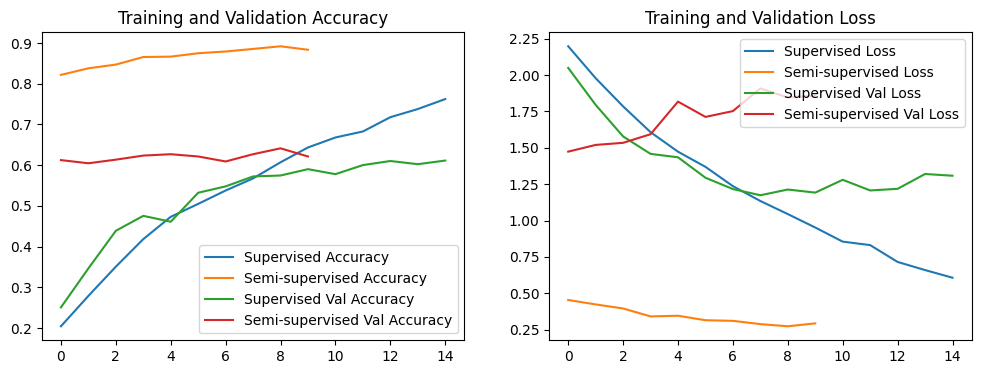

In [ ]:
# Plot training & validation accuracy/loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Supervised Accuracy')
plt.plot(history_semi.history['accuracy'], label='Semi-supervised Accuracy')
plt.plot(history.history['val_accuracy'], label='Supervised Val Accuracy')
plt.plot(history_semi.history['val_accuracy'], label='Semi-supervised Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Supervised Loss')
plt.plot(history_semi.history['loss'], label='Semi-supervised Loss')
plt.plot(history.history['val_loss'], label='Supervised Val Loss')
plt.plot(history_semi.history['val_loss'], label='Semi-supervised Val Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()
